In [25]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn import preprocessing

In [2]:
# Dados carregados em um numpy array
data = np.loadtxt('cluster.dat')

In [3]:
# Dados normalizados que serão utilizados como uma comparação 
data_norm = data/data.max(axis=0)

In [4]:
# divisão para dados de treinamento e dados de teste
np.random.shuffle(data_norm)
train_index_norm = int(data_norm.shape[0]*0.9)
train_data_norm,test_data_norm = np.vsplit(data_norm,[train_index_norm])

In [5]:
def dbscan(data_in: np.ndarray, radius_of_neighborhood: float, number_of_neighbors: int) -> np.ndarray:
    #inicialização da lista de classificação dos pontos
    core_points = []
    border_points = []
    outliers_points = []

    #cluster ajudará na cassificação dos cores junto aos clusters, os dois dicionários serão retornados
    cluster = 0
    cluster_cores = {}
    cluster_borders = {}

    #mepamento de todos os pontos do dataset, mantem a lista de quais não foram visitados ainda
    availabe_points = []
    for i in range(data_in.shape[0]):
        availabe_points.append(i)
    
    #escolha aleatoria de um ponto
    index_list = [np.random.choice(data_in.shape[0])]
    
    #enquanto ainda houver pontos não visitados, este laço é executado
    while True:
        
        #se existe elemento em index_list, ele retira o topo e continua o processamento
        #se não ele escolhe um aleatório dos pontos disponíveis
        if index_list:
            point = index_list.pop(0)
        else:
            if core_points:
                #etapa para verificar se outliers realmente são outliers levando em consideração os dicionários de corepoints formados
                for i in outliers_points:
                    
                    #calcula a distância entre o ponto escolhido e todos os outros do dataset
                    dist = np.linalg.norm(data_in[i]-data_in[core_points],axis=1)

                    neighbors = np.where(dist <= radius_of_neighborhood)[0]

                    core_neighbor_flag = 0
                    for i in neighbors:
                        if not core_neighbor_flag and i in core_points:
                            core_neighbor_flag = 1

                    #se algum dos vizinhos deste "outlier" em questão for core, ele é reclassificado como border
                    if core_neighbor_flag:
                        border_points.append(i)
                        outliers_points.remove(i)

                # Podemos montar os dicionários dos clusters, classificando como um novo cluster, iterando a variável cluster, 
                # já que chegamos em todos os pontos alcançáveis de acordo com os parâmetros passados para a função
            
                cluster_cores[cluster] = np.array(core_points)
                cluster_borders[cluster] = np.array(border_points)
                cluster += 1

                #limpeza das listas já classificadas em um cluster
                core_points.clear()
                border_points.clear()

            #se ainda existem pontos disponíveis
            if availabe_points:
                #escolha de um ponto aleatório dentro dos pontos disponíveis
                point = availabe_points[np.random.choice(len(availabe_points))]
            else:
                #saia do loop se acabarem os pontos disponíveis
                break
        
        #remove o ponto utilizado da lista de pontos disponíveis
        availabe_points.remove(point)
        
        #calcula a distância entre o ponto escolhido e todos os outros do dataset
        dist = np.linalg.norm(data_in[point]-data_in,axis=1)

        #identifica os vizinhos do ponto escolhido de acordo com o raio passado como parâmetro
        neighbors = np.where(dist <= radius_of_neighborhood)[0]
        
        #adiciona todos os pontos alcancáveis pelo ponto escolhido se ele ainda não foi processado e se ele já não está presente em index_list
        # identifica se algum dos vizinhos é um core point, vai ser importante para a classificação como border.
        core_neighbor_flag = 0
        for i in neighbors:
            if (i in availabe_points) and (i not in index_list):
                index_list.append(i)
            if not core_neighbor_flag and i in core_points:
                core_neighbor_flag = 1

        #classificação dos pontos
        if neighbors.shape[0] >= number_of_neighbors:
            core_points.append(point)
        elif core_neighbor_flag:
            border_points.append(point)
        else:
            outliers_points.append(point)

    return cluster_cores, cluster_borders, outliers_points, cluster


def dbscan_fit(test_data: np.ndarray, core_dict: dict, radius_of_neighborhood: float, train_data: np.ndarray):
    test_clusters = {}
    outliers_found = []
    availabe_points = []

    for i in range(test_data.shape[0]):
        availabe_points.append(i)

    for cluster,cores in core_dict.items():
        test_clusters[cluster] = []
        for index in range(test_data.shape[0]):

            dist = np.linalg.norm(train_data[cores]-test_data[index],axis=1)
            if (dist <= radius_of_neighborhood).any():
                test_clusters[cluster].append(index)
                availabe_points.remove(index)

    while availabe_points:
        outliers_found.append(availabe_points.pop())


    return test_clusters, outliers_found

In [6]:
radius = 0.058
nb_of_neighbors = 7

In [7]:
core_train, border_train, outlier_train, n = dbscan(data_in = train_data_norm, radius_of_neighborhood = radius, number_of_neighbors = nb_of_neighbors) 

In [8]:
colors = cm.rainbow(np.linspace(0,1,n))

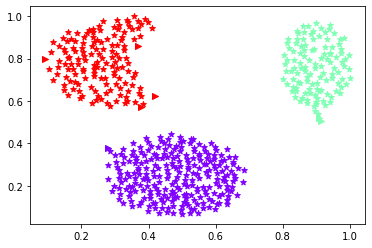

In [9]:
figure, axes = plt.subplots()
for value,color in zip(core_train.values(),colors):
    if value.size:
        x_core, y_core = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_core,y_core,marker='*',color=color)
for value,color in zip(border_train.values(),colors):
    if value.size:
        x_border, y_border = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_border,y_border,marker='>',color=color)
x_outlier, y_outlier = np.hsplit(train_data_norm[outlier_train], 2)
plt.scatter(x_outlier,y_outlier,marker='x',color=color)
draw_circle = []
j = 0
for i in range(x_outlier.shape[0]):
    draw_circle.append(plt.Circle((x_outlier[i,0], y_outlier[i,0]), radius, fill=False))
    axes.add_artist(draw_circle[j])
    j += 1
plt.show()

In [10]:
test_result, test_outlier = dbscan_fit(test_data=test_data_norm, core_dict=core_train, radius_of_neighborhood=radius, train_data = train_data_norm)

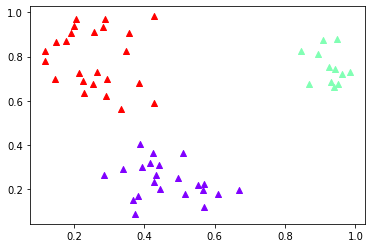

In [11]:
for value,color in zip(test_result.values(),colors):
    x_train, y_train = np.hsplit(test_data_norm[value], 2)
    plt.scatter(x_train,y_train,marker='^',color=color)
x_outlier_test, y_outlier_test = np.hsplit(test_data_norm[test_outlier], 2)
plt.scatter(x_outlier_test,y_outlier_test,marker='x',color='g')

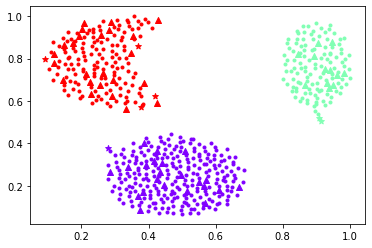

In [12]:
for value,color in zip(core_train.values(),colors):
    x_core, y_core = np.hsplit(train_data_norm[value], 2)
    plt.scatter(x_core,y_core,marker='.',color=color)
for value,color in zip(border_train.values(),colors):
    if value.size:
        x_border, y_border = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_border,y_border,marker='*',color=color)
for value,color in zip(test_result.values(),colors):
    x_test, y_test = np.hsplit(test_data_norm[value], 2)
    plt.scatter(x_test,y_test,marker='^',color=color)
x_outlier_train, y_outlier_train = np.hsplit(train_data_norm[outlier_train], 2)
x_outlier_test, y_outlier_test = np.hsplit(test_data_norm[test_outlier], 2)

plt.scatter(x_outlier_train,y_outlier_train,marker='x',color='r')
plt.scatter(x_outlier_test,y_outlier_test,marker='x',color='g')
plt.show()

# A partir daqui leitura de um arquivo com um número maior de colunas

In [16]:
df_attribbutes = pd.read_csv('CC_GENERAL.csv', sep=',',header=0)

In [17]:
df_attribbutes

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     C10001    40.900749           0.818182      95.40              0.00   
1     C10002  3202.467416           0.909091       0.00              0.00   
2     C10003  2495.148862           1.000000     773.17            773.17   
3     C10004  1666.670542           0.636364    1499.00           1499.00   
4     C10005   817.714335           1.000000      16.00             16.00   
...      ...          ...                ...        ...               ...   
8945  C19186    28.493517           1.000000     291.12              0.00   
8946  C19187    19.183215           1.000000     300.00              0.00   
8947  C19188    23.398673           0.833333     144.40              0.00   
8948  C19189    13.457564           0.833333       0.00              0.00   
8949  C19190   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.945483             0.000000   
2                       0.00      0.000000             1.000000   
3                       0.00    205.788017             0.083333   
4                       0.00      0.000000             0.083333   
...                      ...           ...                  ...   
8945                  291.12      0.000000             1.000000   
8946                  300.00      0.000000             1.000000   
8947                  144.40      0.000000             0.833333   
8948                    0.00     36.558778             0.000000   
8949                    0.00    127.040008             0.666667   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000000                          0.083333   
1                       0.000000                          0.000000   
2                       1.000000                          0.000000   
3                       0.083333                          0.000000   
4                       0.083333                          0.000000   
...                          ...                               ...   
8945                    0.000000                          0.833333   
8946                    0.000000                          0.833333   
8947                    0.000000                          0.666667   
8948                    0.000000                          0.000000   
8949                    0.666667                          0.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              2        1000.0   
1                   0.250000                 4              0        7000.0   
2                   0.000000                 0             12        7500.0   
3                   0.083333                 1              1        7500.0   
4                   0.000000                 0              1        1200.0   
...                      ...               ...            ...           ...   
8945                0.000000                 0              6        1000.0   
8946                0.000000                 0              6        1000.0   
8947                0.000000                 0              5        1000.0   
8948                0.166667                 2              0         500.0   
8949                0.333333                 2             23        1200.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0      201.802084        139.509787          0.000000      12  
1     4103.032597       1072.340217          0.222222      12  
2      622.066742        627.284787          0.000000      12  
3        0.000000               NaN          0.000000      12  
4      678.334763        244.791237          0.000000      12  
...           ...               ...               ...     ...  
8945   325.594462         48.886365  

In [23]:
df_treated = df_attribbutes.drop(columns =['CUST_ID'])

In [24]:
df_treated

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       40.900749           0.818182      95.40              0.00   
1     3202.467416           0.909091       0.00              0.00   
2     2495.148862           1.000000     773.17            773.17   
3     1666.670542           0.636364    1499.00           1499.00   
4      817.714335           1.000000      16.00             16.00   
...           ...                ...        ...               ...   
8945    28.493517           1.000000     291.12              0.00   
8946    19.183215           1.000000     300.00              0.00   
8947    23.398673           0.833333     144.40              0.00   
8948    13.457564           0.833333       0.00              0.00   
8949   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                      95.40      0.000000             0.166667   
1                       0.00   6442.945483             0.000000   
2                       0.00      0.000000             1.000000   
3                       0.00    205.788017             0.083333   
4                       0.00      0.000000             0.083333   
...                      ...           ...                  ...   
8945                  291.12      0.000000             1.000000   
8946                  300.00      0.000000             1.000000   
8947                  144.40      0.000000             0.833333   
8948                    0.00     36.558778             0.000000   
8949                    0.00    127.040008             0.666667   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000000                          0.083333   
1                       0.000000                          0.000000   
2                       1.000000                          0.000000   
3                       0.083333                          0.000000   
4                       0.083333                          0.000000   
...                          ...                               ...   
8945                    0.000000                          0.833333   
8946                    0.000000                          0.833333   
8947                    0.000000                          0.666667   
8948                    0.000000                          0.000000   
8949                    0.666667                          0.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              2        1000.0   
1                   0.250000                 4              0        7000.0   
2                   0.000000                 0             12        7500.0   
3                   0.083333                 1              1        7500.0   
4                   0.000000                 0              1        1200.0   
...                      ...               ...            ...           ...   
8945                0.000000                 0              6        1000.0   
8946                0.000000                 0              6        1000.0   
8947                0.000000                 0              5        1000.0   
8948                0.166667                 2              0         500.0   
8949                0.333333                 2             23        1200.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0      201.802084        139.509787          0.000000      12  
1     4103.032597       1072.340217          0.222222      12  
2      622.066742        627.284787          0.000000      12  
3        0.000000               NaN          0.000000      12  
4      678.334763        244.791237          0.000000      12  
...           ...               ...               ...     ...  
8945   325.594462         48.886365          0.500000       6  
8946   275.861322               NaN          0.000000       6  
8947    81

In [29]:
x = df_treated.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(x)

In [41]:
# divisão para dados de treinamento e dados de teste
np.random.shuffle(df_scaled)
train_index_norm = int(df_scaled.shape[0]*0.9)
train_data_norm,test_data_norm = np.vsplit(df_scaled,[train_index_norm])

In [42]:
core_train_df, border_train_df, outlier_train_df, n_df = dbscan(data_in = train_data_norm, radius_of_neighborhood = radius, number_of_neighbors = nb_of_neighbors) 


In [46]:
n_df

37

In [47]:
core_train_df

{0: array([4797,  585,  586,  831,  933, 1170, 1330, 1399, 1404, 1418, 1481,
        1545, 1855, 1949, 2123, 2180, 2314, 2358, 2382, 2493, 2648, 2722,
        2960, 3009, 3145, 3196, 3852, 4000, 4165, 4520, 4657, 4707, 4851,
        5070, 5263, 5434, 5489, 5699, 5893, 6139, 6338, 6404, 6495, 6637,
        6736, 6815, 7351, 7512, 7535, 7536, 7651, 7840, 7877, 7966,  329,
         496,  519, 1309, 1941, 2502, 3713, 3822, 4187, 4650, 4748, 4762,
        4924, 6493, 6847, 6927, 7088, 7266, 6101, 6481, 7081,  743,  121,
         367, 1539, 1947, 2891, 5788, 5963, 6051, 6674, 7313, 7631, 6222,
        3421, 5096, 5202, 1837, 2533, 5458,  844,   89,  461,  851, 1751,
        6103, 6723,  721, 3921, 4436, 2488, 7592,  248, 7734,  717,  207,
        2279, 3778, 4450, 6838, 3969, 2067, 5530, 1372, 1020, 2132, 6296,
        7978, 2998], dtype=int64),
 1: array([2816,  636, 1322, 4352, 5703, 6176, 6180, 6460, 7208, 7611, 7737,
        8046, 4451, 6182], dtype=int64),
 2: array([2187, 5151, 6725, 7

In [45]:
border_train_df

{0: array([ 547, 7508, 3930, 7814, 3875, 5589, 3259, 5667, 6843, 5611, 3812,
        7299, 7388, 7253, 7107, 6214, 7688,   94, 2120, 5559, 1630, 5942],
       dtype=int64),
 1: array([4200, 6715], dtype=int64),
 2: array([2186, 3439, 4211, 1574, 7629], dtype=int64),
 3: array([7441, 6655, 1575, 3746, 7875, 7583, 2515, 2735, 2677, 6821, 6276,
        7831, 5566,  670,  815,  938,  430, 3106,  549,  155,  280, 3590,
        3527, 6840, 5322, 2980, 6870, 2255, 3172, 7904, 1411, 3835, 3842,
        2804, 2878, 1182, 3933, 6209, 3300, 2640, 7117, 2650, 6474, 7946,
        3071, 4480, 2864, 6202, 1172,  913, 1269, 1612, 2335, 2396, 4094,
         711, 5090, 1080, 7437, 1356, 7037, 6128, 6265, 5483,  424, 3680,
        6256, 2056, 6125, 5331, 6425, 2711, 7008], dtype=int64),
 4: array([1480, 1250, 1110, 2179, 7245, 2400, 1688, 5277, 7240], dtype=int64),
 5: array([1091, 2708, 3906,  265, 7320], dtype=int64),
 6: array([2590, 6809, 7637], dtype=int64),
 7: array([ 382,  548, 5767], dtype=int64

In [52]:
len(outlier_train_df)

6576